# Imports

In [0]:
import pandas as pd 
import numpy as np
import requests
import io
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab import drive
import os
import json
import random

In [3]:
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


# Helper Functions

In [0]:
logpath = 'drive/My Drive/mmath_cs/CHI_2020/Typealike/study_2/logs/'
logfns = os.listdir(logpath)

# these are columns that define a single trial
columns = ['Participant',            # participant id (P01, P02, ...)
           'TempBlock',
           'Block',                  # upto 3
           'Sequence',               # upto 360
           'Trial',                  # upto 720
           'Target_Type',              # what condition this particpant did (typing, pointing, gesture)
           'Target_Name',                  # whats the specific label of this target
           'Start_Time',
           'End_Time',
           'First_Reaction_Time',
           'Mode_In_Time',  #time in ms
           'Mode_Out_Time',
           'Execution_Time', # mode_in_time + mode_out_time
           'Reference_Action_Count',
           'Incorrect_Action_Count',
           'Error',
           'IV_Surface',
           'IV_Orientation',
           'IV_Form',
           'IV_Hand',
           'Reference_Task'
            ]

# time format in the example log is like 2018/07/10-16:41:54.4902
# see https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior
# time_format = '%Y/%m/%d-%H:%M:%S.%f'
time_format = '%Y-%m-%d %H:%M:%S.%f'

In [0]:
# helper functions

# https://stackoverflow.com/questions/17060039/split-string-at-nth-occurrence-of-a-given-character
def splitn(string, spliton, n):
    """split 'string' on nth occurence of 'spliton'
    """
    groups = string.split(spliton)
    return spliton.join(groups[:n]), spliton.join(groups[n:])


def ms_delta(t):
    """convert timedelta t to milliseconds
    """
    return round(t.seconds * 1000 + t.microseconds / 1000)

In [206]:
logpath

'drive/My Drive/mmath_cs/CHI_2020/Typealike/study_2/logs/'

## Create CSV from log files based on the above format

In [350]:
# data = open(logpath+'../mode_switching.csv', 'w')
# data.write(','.join(columns) + '\n')

for logfn in logfns:

#     print(logfn)
    filename = logfn.replace(".txt",".csv")
    data = open(logpath+'../csv/'+filename, 'w')
    data.write(','.join(columns) + '\n')
    
    modeSwitch=False
    currentTaskFirstAttempt=0;
    previousTaskEndTime=0;
    nextTaskStart=False;
    prev_task=""
    
    log = open(logpath + logfn, 'r')
    
#     initalize a dictionary of values we'll write to the datafile
    d = {e:0 for e in columns}
    
    # initalize temporary values
    trial_start_time = 0

    # we'll go through line-by-line
    line_num = 0
    trial = 0
    trial_started = False
    first_reaction_recorded = False
    reference_action_count = 0
    incorrect_action_count = 0
    keys_list = []
    for row in log:
#         print(row)
        if row[0] == '#':             
            continue
        line_num += 1
        # split the line
        row_list = row.strip().split(',')
#         if row_list[1] == :
#           pass
#         if row_list[2]
        if trial_started:
          
          if row_list[1] == 'I':
            if row_list[2] == "posture" and d['Target_Name'] != row_list[3]:
              if row_list[3] not in ["typing", "no_posture"]:
                incorrect_action_count +=1
              else:
                reference_action_count +=1
                
            if not first_reaction_recorded and row_list[2] == 'keyboard':
              first_reaction_time = row_list[0]
              first_reaction_recorded = True
            if d['Target_Type'] == "shortcut":
              if row_list[3] == "keypressed":
                keys_list.append(row_list[4])
              elif row_list[3] == "mousepressed":
                keys_list.append("mousepressed")
#                 incorrect_action_count +=1
    
        if row_list[1] == 'E':
          row_split_list = splitn(row, ',', 3)
  #         experiment_block = (row_list[1], row_list[2])
          row_inner_dict = {}
          try:
              # parse the json event data
  #                 print("PARSIG JSON")
  #                 print(r[1])
#               print(row_split_list)
              row_inner_dict = json.loads(row_split_list[1])
          except Exception as e:
              print('error parsing json event data on row{}: {}\n{}'.format(line_num, row_list[3], e))

          if row_list[2] == "experiment":
            d['Participant'] = row_inner_dict['participantid']

          if row_list[2] == "trial":
#             print(row)

            if row_inner_dict["type"] == "start":
              trial_started = True
              first_reaction_recorded = False
              d['Start_Time'] = row_list[0]
  #             d['Participant'] = row_inner_dict['participantid']
              d['Target_Type'] = row_inner_dict["targetType"]
              d['Target_Name'] = row_inner_dict["label"]
              d['Block'] = row_inner_dict["blockNum"]
              d['Sequence'] = row_inner_dict["sequenceNum"]
              d['Trial'] = trial
#               if row_inner_dict["type"] == "posture":
#               if row_inner_dict["targetType"] == "posture":
                
  
              trial+=1
            elif row_inner_dict["type"] == "end":
              trial_started = False
              d['End_Time'] = row_list[0]
              d['First_Reaction_Time'] = first_reaction_time if d['Target_Type'] == 'word' else row_list[0] # ["shortcut", "posture", "click"]
#               d['Mode_In_Time'] = int(d['First_Reaction_Time']) - int(d['Start_Time'])
              d['Reference_Action_Count'] = reference_action_count
              d['Incorrect_Action_Count'] = incorrect_action_count
              d['Error'] = False if row_inner_dict["action"] == "hit" else True
              if d["Target_Type"] == "shortcut" and len(keys_list) > 1:
#                 if :
                d['Incorrect_Action_Count'] = 1

              reference_action_count = 0
              incorrect_action_count = 0
              keys_list = []
  

              # save to log
              datarow = [d[k] for k in columns]
              datarow_csv = ','.join(str(i) for i in datarow)
    #                     print(datarow_csv)
              data.write(datarow_csv + '\n')
            
    data.close()
    print(filename)

participant_31_experiment_2019-08-29-18-49-40.csv
participant_50_experiment_2019-09-10-14-21-34.csv
participant_49_experiment_2019-09-06-20-00-11.csv
participant_48_experiment_2019-09-06-18-51-31.csv
participant_47_experiment_2019-09-06-16-47-27.csv
participant_45_experiment_2019-09-05-18-50-20.csv
participant_44_experiment_2019-09-05-17-25-07.csv
participant_43_experiment_2019-09-05-16-01-45.csv
participant_42_experiment_2019-09-05-14-19-57.csv
participant_41_experiment_2019-09-04-19-05-57.csv
participant_40_experiment_2019-09-04-18-12-17.csv
participant_39_experiment_2019-09-04-16-12-13.csv
participant_38_experiment_2019-09-04-14-54-31.csv
participant_37_experiment_2019-09-03-23-06-46.csv
participant_36_experiment_2019-09-03-16-58-26.csv
participant_35_experiment_2019-09-03-15-57-34.csv
participant_34_experiment_2019-09-02-17-51-29.csv
participant_33_experiment_2019-09-02-15-48-35.csv
participant_32_experiment_2019-08-30-16-52-53.csv
participant_46_experiment_2019-09-05-22-37-21.csv


In [321]:
f = "/content/drive/My Drive/mmath_cs/CHI_2020/Typealike/study_2/csv/participant_45_experiment_2019-09-05-18-50-20.csv"
df = pd.read_csv(f)
# df.loc[(df["Target_Type"]=="word")&(df["Block"]==5) & (df["Sequence"]==6)]#.count()#.sort_values(by=["Block","Sequence"])#"Block","Sequence").head(36)
df.loc[(df["Target_Type"] == "shortcut") & (df["Incorrect_Action_Count"] > 0)]

,Participant,TempBlock,Block,Sequence,Trial,Target_Type,Target_Name,Start_Time,End_Time,First_Reaction_Time,Mode_In_Time,Mode_Out_Time,Execution_Time,Reference_Action_Count,Incorrect_Action_Count,Error,IV_Surface,IV_Orientation,IV_Form,IV_Hand,Reference_Task
101,participant_45,0,1,14,101,shortcut,N,1567724050504,1567724052434,1567724052434,0,0,0,0,1,False,0,0,0,0,0
275,participant_45,0,3,29,275,shortcut,I,1567724437119,1567724440617,1567724440617,0,0,0,0,1,False,0,0,0,0,0
521,participant_45,0,7,8,521,shortcut,T,1567724926403,1567724928837,1567724928837,0,0,0,0,1,False,0,0,0,0,0



## Form a single big dataframe for all participants

### helper function

In [0]:
def get_mode_in_out_time(df):
  mode_in_time_list = pd.Series([])
  mode_out_time_list = pd.Series([])
  execution_time_list = pd.Series([])
  exp_block_list = pd.Series([])
  ref_task_list = pd.Series([])
  surface_iv_list = pd.Series([])
  hand_iv_list = pd.Series([])
  form_iv_list = pd.Series([])
  orientation_iv_list = pd.Series([])

  for i in range(len(df)): 
    start_time = df["Start_Time"][i]
    end_time = df["End_Time"][i]
    first_reaction_time = df["First_Reaction_Time"][i]
    mode_in_time_list[i] = 0 if i == 0 else mode_out_time_list[i-1]
    #   print(i, " ", len(df))
    mode_out_time_list[i] = 0 if (i+1 == len(df) or  df["Block"][i] != df["Block"][i+1]) else (df["First_Reaction_Time"][i+1] - df["First_Reaction_Time"][i])
    exp_block_list[i] = int(df["Block"][i]/2)
    execution_time_list[i] = mode_in_time_list[i] + mode_out_time_list[i]
    if df["Target_Type"][i] in ["word", "click"]:
      ref_task_list[i] = "NA"
      surface_iv_list[i] = "NA"
      hand_iv_list[i] = "NA"
      form_iv_list[i] = "NA"
      orientation_iv_list[i] = "NA"
    else:
      ref_task_list[i] = df["Target_Type"][i-1]
      if df["Target_Type"][i] == "shortcut":
        surface_iv_list[i] = "shortcut"
        hand_iv_list[i] = "shortcut"
        form_iv_list[i] = "shortcut"
        orientation_iv_list[i] = "shortcut"
      else:
        t_n_split = df["Target_Name"][i].split('_')
        hand_iv_list[i] = t_n_split[0]
        form_iv_list[i] = t_n_split[1]
        orientation_iv_list[i] = "180" if t_n_split[2] == "0" else "0" if t_n_split[2] =="180" else "90"
        surface_iv_list[i] = t_n_split[3]
        
        
#   df_usable.insert(4, "TempBlock", exp_block_list)
#   df_usable.insert(10, "Mode_In_Time", mode_in_time_list)
#   df_usable.insert(11, "Mode_Out_Time", mode_out_time_list)
  df["TempBlock"] = exp_block_list.values
  df["Mode_In_Time"] = mode_in_time_list.values
  df["Mode_Out_Time"] = mode_out_time_list.values
  df["Execution_Time"] = execution_time_list.values
  df["Reference_Task"] = ref_task_list.values
  df["IV_Surface"] = surface_iv_list.values
  df["IV_Orientation"] = orientation_iv_list.values
  df["IV_Form"] = form_iv_list.values
  df["IV_Hand"] = hand_iv_list.values
  
#   df_usable = df_usable.rename(columns={"Sequence":"Sub_Sequence", "Block":"Sequence", "TempBlock": "Block"})

### now read and merge

In [353]:
f = "/content/drive/My Drive/mmath_cs/CHI_2020/Typealike/study_2/csv/participant_31_experiment_2019-08-29-18-49-40.csv"
df_all = pd.read_csv(f)
get_mode_in_out_time(df_all)
csv_Path = "/content/drive/My Drive/mmath_cs/CHI_2020/Typealike/study_2/csv/"
csv_files = os.listdir(csv_Path)

for csv in csv_files:
  df = pd.read_csv(csv_Path+csv)
  if df["Participant"][0] == "participant_31" or df["Participant"][0] == "pilot_nalin":
    continue
#   print()
  get_mode_in_out_time(df)
  df_all = df_all.append(df, ignore_index=True)
#   print(df["Participant"][0])
#   if df["Participant"][0] == "participant_44":
#     dd = df.loc[df["Reference_Action_Count"] < df["Incorrect_Action_Count"]]
#     break
  print(df["Participant"][0], df.loc[df["Reference_Action_Count"] < df["Incorrect_Action_Count"]]["Incorrect_Action_Count"].count())
# df_all.loc[(df_all["Reference_Action_Count"] < df_all["Incorrect_Action_Count"]) & (df_all["Target_Name"]=="Left_Open_180_Below")].groupby(["Participant","Block"]).first()#.groupby(["Block","Sequence"]).first()
# set(df_all.loc[(df_all["Reference_Action_Count"] < df_all["Incorrect_Action_Count"])]["Target_Name"])#) & (df_all["Target_Name"]=="Right_Close_0_Below")]
# {'Right_Close_0_Below', 'Right_Close_180_Beside', 'Right_Open_180_Below'}
# df_all.loc[(df_all["Reference_Action_Count"] < df_all["Incorrect_Action_Count"])]

participant_50 13
participant_49 15
participant_48 8
participant_40 13
participant_47 13
participant_39 12
participant_45 12
participant_38 11
participant_44 19
participant_37 14
participant_43 10
participant_36 8
participant_42 13
participant_41 12
participant_35 15
participant_34 18
participant_33 11
participant_32 16
participant_46 12


In [354]:
df_all.count()

Participant               14400
TempBlock                 14400
Block                     14400
Sequence                  14400
Trial                     14400
Target_Type               14400
Target_Name               14400
Start_Time                14400
End_Time                  14400
First_Reaction_Time       14400
Mode_In_Time              14400
Mode_Out_Time             14400
Execution_Time            14400
Reference_Action_Count    14400
Incorrect_Action_Count    14400
Error                     14400
IV_Surface                14400
IV_Orientation            14400
IV_Form                   14400
IV_Hand                   14400
Reference_Task            14400
dtype: int64

# Analysis

## Participants

## Postures

### How many mode-errors are there for each task type



In [355]:
df_all.loc[(df_all["Reference_Action_Count"] >= df_all["Incorrect_Action_Count"])].groupby("Target_Type")["Participant"].count()

Target_Type
click       3600
posture     3455
shortcut    3489
word        3600
Name: Participant, dtype: int64

In [0]:
# df_all.loc[(df_all["Participant"] == "participant_36") & (df_all["Target_Type"]=="word")]#.groupby("Target_Type")["Participant"]
# df_all.loc[(df_all["Target_Type"]=="shortcut")]#.groupby("Target_Type")["Participant"]
# df_all.loc[(df_all["Participant"] == "participant_36") & (df_all["Target_Type"]=="shortcut")].count()

### How many task-errors are there for each task type?

In [362]:
# df_all.loc[(df_all["Error"]==True) & (df_all["Target_Type"]=="posture")]#.groupby("Target_Type").count()
# # print("Task Error")
e = df_all.loc[(df_all["Error"]==True)].groupby("Target_Type")["Participant"].count()
p_id = ("posture","shortcut","word")
[(p_id[i],e[i]) for i in range(3)]

[('posture', 6), ('shortcut', 13), ('word', 74)]

In [0]:
# Rename columns
df_all = df_all.rename(columns={"Sequence":"Sub_Sequence", "Block":"Sequence", "TempBlock": "Block"})

### Calculate mode-in and mode-out **time**

#### Create a dataframe that does not include trials with mode-errors/task-errors.

In [363]:
df_filtered = df_all.loc[(df_all["Reference_Action_Count"] >= df_all["Incorrect_Action_Count"]) & (df_all["Error"]==False)]
df_filtered.count()

Participant               14053
Block                     14053
Sequence                  14053
Sub_Sequence              14053
Trial                     14053
Target_Type               14053
Target_Name               14053
Start_Time                14053
End_Time                  14053
First_Reaction_Time       14053
Mode_In_Time              14053
Mode_Out_Time             14053
Execution_Time            14053
Reference_Action_Count    14053
Incorrect_Action_Count    14053
Error                     14053
IV_Surface                14053
IV_Orientation            14053
IV_Form                   14053
IV_Hand                   14053
Reference_Task            14053
dtype: int64

In [364]:
df_filtered.head()

,Participant,Block,Sequence,Sub_Sequence,Trial,Target_Type,Target_Name,Start_Time,End_Time,First_Reaction_Time,Mode_In_Time,Mode_Out_Time,Execution_Time,Reference_Action_Count,Incorrect_Action_Count,Error,IV_Surface,IV_Orientation,IV_Form,IV_Hand,Reference_Task
0,participant_31,0,0,0,0,click,click me,1567118993864,1567118995310,1567118995310,0,1335,1335,0,0,False,NA,NA,NA,NA,NA
1,participant_31,0,0,0,1,posture,Left_Close_0_On,1567118995331,1567118996645,1567118996645,1335,1758,3093,26,4,False,On,180,Close,Left,click
2,participant_31,0,0,1,2,word,fully,1567118996665,1567118999400,1567118998403,1758,2772,4530,0,0,False,NA,NA,NA,NA,NA
3,participant_31,0,0,1,3,posture,Left_Close_0_Below,1567118999434,1567119001175,1567119001175,2772,2024,4796,24,0,False,Below,180,Close,Left,word
4,participant_31,0,0,2,4,click,click me,1567119001198,1567119003199,1567119003199,2024,1678,3702,0,0,False,NA,NA,NA,NA,NA


#### Prepare data to plot

In [0]:
data_filtered = df_filtered.loc[(df_filtered['Target_Type'] == "shortcut") | (df_filtered['Target_Type'] == "posture")]
data_filtered_word = df_filtered.loc[(df_filtered['Reference_Task'] == "word")]
data_filtered_click = df_filtered.loc[(df_filtered['Reference_Task'] == "click")]


In [366]:
data_baseline = df_all.loc[(df_all['Target_Type'] != "shortcut") & (df_all['Target_Type'] != "posture")]
# data_baseline.count()
data_baseline.loc[data_baseline["Error"]==True].count()


Participant               74
Block                     74
Sequence                  74
Sub_Sequence              74
Trial                     74
Target_Type               74
Target_Name               74
Start_Time                74
End_Time                  74
First_Reaction_Time       74
Mode_In_Time              74
Mode_Out_Time             74
Execution_Time            74
Reference_Action_Count    74
Incorrect_Action_Count    74
Error                     74
IV_Surface                74
IV_Orientation            74
IV_Form                   74
IV_Hand                   74
Reference_Task            74
dtype: int64

### Mode_In Time (filtered vs unfiltered)

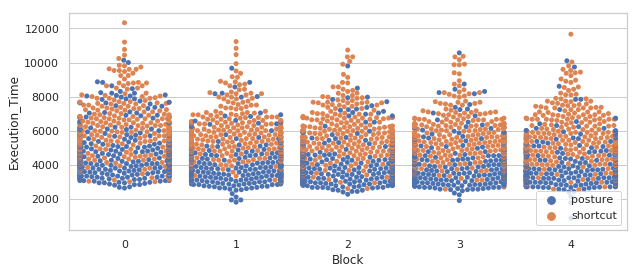

In [367]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,4))
# plt.xticks(rotation=90)
# ax = sns.barplot(x="Block", y="Mode_In_Time", hue="Target_Type", data=data_filtered_word, capsize=0.1, ci=100)
ax = sns.swarmplot(x="Block", y="Execution_Time",hue="Target_Type", data=data_filtered_word)
ax.legend(loc='lower right')

### Mode_Out Time (filtered vs unfiltered)

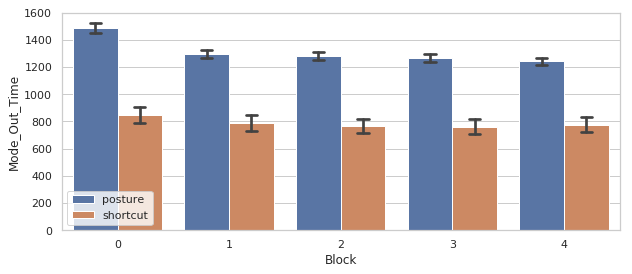

In [368]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,4))
# plt.xticks(rotation=90)
ax = sns.barplot(x="Block", y="Mode_Out_Time", hue="Target_Type", data=data_filtered, capsize=0.1)
ax.legend(loc='lower left')

### Total Execution Time (filtered vs unfiltered)
#### Total Execution Time = (mode-in + mode-out)

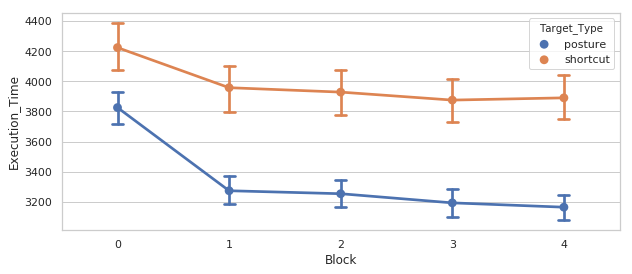

In [369]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,4))
# plt.xticks(rotation=90)
# ax = sns.barplot(x="Block", y="Execution_Time", hue="Target_Type", data=data_filtered, capsize=0.1, ci=95)
ax = sns.pointplot(x="Block", y="Execution_Time",hue="Target_Type", err_style="bars", data=data_filtered, capsize=0.1, ci=95, dashes=True)
# ax = sns.swarmplot(x="Block", y="Execution_Time",hue="Target_Type", data=data_filtered)
# ax = sns.lineplot(x="Block", y="Execution_Time", hue="Target_Type", units="subject", estimator=None, lw=1, data=fmri.query("region == 'frontal'"))

# ax.legend(loc='upper right')#, bbox_to_anchor=(0.8, 0.5), ncol=1)
# plt.xlim(0, 4)
# plt.grid('off')
# Add rectangle
# ax.add_patch(
# patches.Rectangle(
# (50, 50), # (x,y)
# 50, # width
# 50, # height
# # You can add rotation as well with 'angle'
# alpha=0.3, facecolor="red", edgecolor="black", linewidth=3, linestyle='solid'
# )
# )

arr = {0:-0.6,1:0.2,2:1.4,3:2.2,4:3.4, 5:4.2,6:5.4,7:6.2,8:7.4,9:8.2}
# for index, row in data_filtered.groupby(["Block","Target_Type"]).mean().reset_index().iterrows():
# #     print(row["Execution_Time"])
# #     print(index)
#     ax.text(arr[index]/2,-101, round(row["Execution_Time"]/1000,2), color='black')

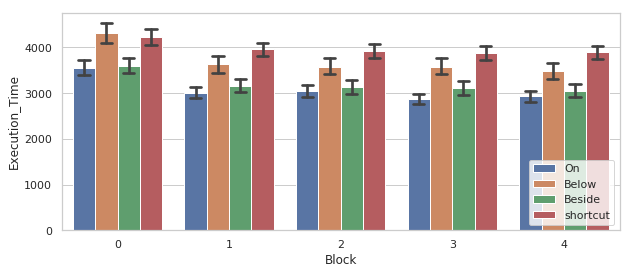

In [370]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,4))
# ax = sns.pointplot(x="Block", y="Execution_Time",hue="IV_Surface", err_style="bars", data=data_filtered, capsize=0.1, ci=95, dashes=True)
ax = sns.barplot(x="Block", y="Execution_Time", hue="IV_Surface", data=data_filtered, capsize=0.1, ci=95)
ax.legend(loc='lower right')#, bbox_to_anchor=(0.8, 0.5), ncol=1)

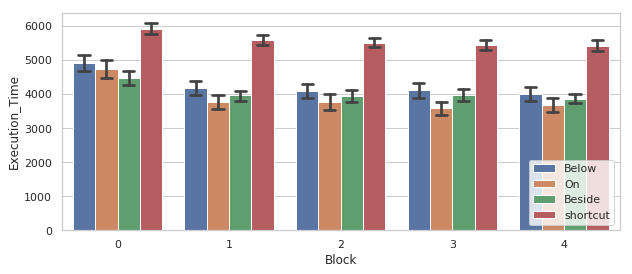

In [371]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,4))
# ax = sns.pointplot(x="Block", y="Execution_Time",hue="IV_Surface", err_style="bars", data=data_filtered, capsize=0.1, ci=95, dashes=True)
ax = sns.barplot(x="Block", y="Execution_Time", hue="IV_Surface", data=data_filtered_word, capsize=0.1, ci=95)
ax.legend(loc='lower right')#, bbox_to_anchor=(0.8, 0.5), ncol=1)

No handles with labels found to put in legend.


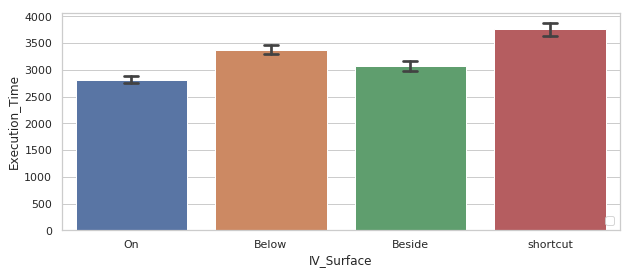

In [381]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,4))
# ax = sns.pointplot(x="Block", y="Execution_Time",hue="IV_Surface", err_style="bars", data=data_filtered, capsize=0.1, ci=95, dashes=True)
ax = sns.barplot(x="IV_Surface", y="Execution_Time", data=data_filtered, capsize=0.1, ci=95,estimator=np.median)
ax.legend(loc='lower right')#, bbox_to_anchor=(0.8, 0.5), ncol=1)

No handles with labels found to put in legend.


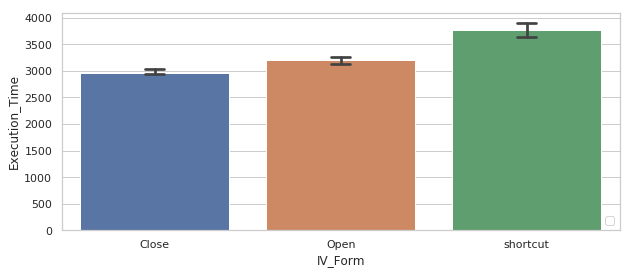

In [374]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,4))
# ax = sns.pointplot(x="Block", y="Execution_Time",hue="IV_Surface", err_style="bars", data=data_filtered, capsize=0.1, ci=95, dashes=True)
ax = sns.barplot(x="IV_Form", y="Execution_Time", data=data_filtered, capsize=0.1, ci=95,estimator=np.median)
ax.legend(loc='lower right')#, bbox_to_anchor=(0.8, 0.5), ncol=1)

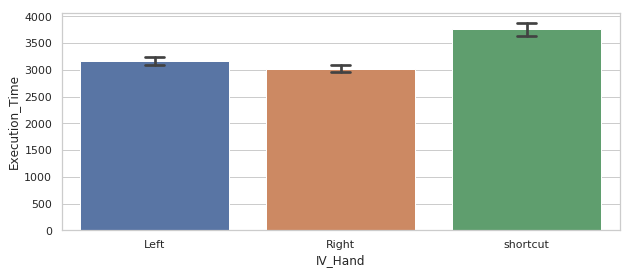

In [375]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,4))
# ax = sns.pointplot(x="Block", y="Execution_Time",hue="IV_Surface", err_style="bars", data=data_filtered, capsize=0.1, ci=95, dashes=True)
ax = sns.barplot(x="IV_Hand", y="Execution_Time", data=data_filtered, capsize=0.1, ci=95,estimator=np.median)
# ax.legend(loc='lower right')#, bbox_to_anchor=(0.8, 0.5), ncol=1)

Todo


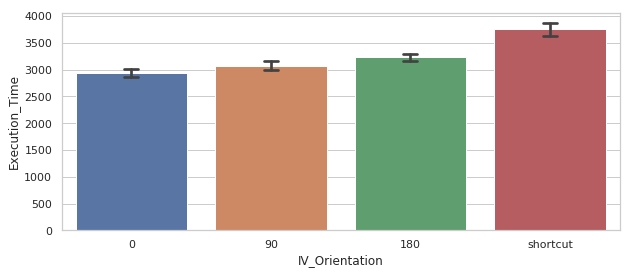

In [380]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,4))
# ax = sns.pointplot(x="IV_Orientation", y="Execution_Time", err_style="bars", data=data_filtered, capsize=0.1, ci=95, dashes=True)
ax = sns.barplot(x="IV_Orientation", y="Execution_Time", data=data_filtered, capsize=0.1, ci=95,estimator=np.median, order=["0","90","180","shortcut"])
# ax.legend(loc='lower right')#, bbox_to_anchor=(0.8, 0.5), ncol=1)